In [1058]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from scipy.stats import wasserstein_distance, entropy
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from DatasetExt import *
import matplotlib.pyplot as plt
#np.random.seed(42)


## Dataset Load

In [1093]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
columns = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status", "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"]
df = pd.read_csv(url, names=columns, na_values=" ?")

df.drop(columns=["fnlwgt", "education", "relationship", "native-country"], inplace=True)
numerical_features = ["age", "education-num", "capital-gain", "capital-loss", "hours-per-week"]
categorical_features = ["workclass", "marital-status", "occupation", "race", "sex"]
target_variable='income'

In [1060]:
'''url_german = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data"
columns_german = [
    "Status", "Duration", "CreditHistory", "Purpose", "CreditAmount",
    "Savings", "Employment", "InstallmentRate", "PersonalStatusSex",
    "Debtors", "ResidenceSince", "Property", "Age", "OtherInstallmentPlans",
    "Housing", "NumberCredits", "Job", "PeopleLiable", "Telephone", "ForeignWorker", "CreditRisk"
]
df = pd.read_csv(url_german, delim_whitespace=True, names=columns_german)

df.drop(columns=["Telephone", "ForeignWorker"], inplace=True)
numerical_features = ["Duration", "CreditAmount", "InstallmentRate", "ResidenceSince", "Age", "NumberCredits", "PeopleLiable"]
categorical_features = list(set(df.columns) - set(numerical_features) - {"CreditRisk"})
target_variable = 'CreditRisk' '''

'url_german = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data"\ncolumns_german = [\n    "Status", "Duration", "CreditHistory", "Purpose", "CreditAmount",\n    "Savings", "Employment", "InstallmentRate", "PersonalStatusSex",\n    "Debtors", "ResidenceSince", "Property", "Age", "OtherInstallmentPlans",\n    "Housing", "NumberCredits", "Job", "PeopleLiable", "Telephone", "ForeignWorker", "CreditRisk"\n]\ndf = pd.read_csv(url_german, delim_whitespace=True, names=columns_german)\n\ndf.drop(columns=["Telephone", "ForeignWorker"], inplace=True)\nnumerical_features = ["Duration", "CreditAmount", "InstallmentRate", "ResidenceSince", "Age", "NumberCredits", "PeopleLiable"]\ncategorical_features = list(set(df.columns) - set(numerical_features) - {"CreditRisk"})\ntarget_variable = \'CreditRisk\' '

## Missing Value Injection

In [1061]:
for col in numerical_features:
    missing_indices = np.random.choice(df.index, int(len(df) * 0.01), replace=False)
    df.loc[missing_indices, col] = np.nan

missing_values = df.isnull().sum()
print("Missing values per column:")
print(missing_values)

Missing values per column:
age                325
workclass         1836
education-num      325
marital-status       0
occupation        1843
race                 0
sex                  0
capital-gain       325
capital-loss       325
hours-per-week     325
income               0
dtype: int64


## Outlier Injection

In [1062]:
'''fig, axes = plt.subplots(1, len(numerical_features), figsize=(20, 5))

for i, col in enumerate(numerical_features):
    df.boxplot(column=col, ax=axes[i])
    axes[i].set_title(f'{col}')

plt.tight_layout()
plt.show()'''

"fig, axes = plt.subplots(1, len(numerical_features), figsize=(20, 5))\n\nfor i, col in enumerate(numerical_features):\n    df.boxplot(column=col, ax=axes[i])\n    axes[i].set_title(f'{col}')\n\nplt.tight_layout()\nplt.show()"

In [1063]:
'''for col in numerical_features:
    Q1 = df_adult[col].quantile(0.25)
    Q3 = df_adult[col].quantile(0.75)
    IQR = Q3 - Q1
    
    outlier_high = Q3 + 3 * IQR
    outlier_low = Q1 - 3 * IQR

    num_outliers = int(len(df_adult) * 0.01)
    high_outlier_indices = np.random.choice(df_adult.index, num_outliers // 2, replace=False)
    low_outlier_indices = np.random.choice(df_adult.index.difference(high_outlier_indices), num_outliers // 2, replace=False)

    df_adult.loc[high_outlier_indices, col] = outlier_high * 3
    df_adult.loc[low_outlier_indices, col] = outlier_low * 3'''

'for col in numerical_features:\n    Q1 = df_adult[col].quantile(0.25)\n    Q3 = df_adult[col].quantile(0.75)\n    IQR = Q3 - Q1\n    \n    outlier_high = Q3 + 3 * IQR\n    outlier_low = Q1 - 3 * IQR\n\n    num_outliers = int(len(df_adult) * 0.01)\n    high_outlier_indices = np.random.choice(df_adult.index, num_outliers // 2, replace=False)\n    low_outlier_indices = np.random.choice(df_adult.index.difference(high_outlier_indices), num_outliers // 2, replace=False)\n\n    df_adult.loc[high_outlier_indices, col] = outlier_high * 3\n    df_adult.loc[low_outlier_indices, col] = outlier_low * 3'

In [1064]:
'''fig, axes = plt.subplots(1, len(numerical_features), figsize=(20, 5))

for i, col in enumerate(numerical_features):
    df_adult.boxplot(column=col, ax=axes[i])
    axes[i].set_title(f'{col}')

plt.tight_layout()
plt.show()'''

"fig, axes = plt.subplots(1, len(numerical_features), figsize=(20, 5))\n\nfor i, col in enumerate(numerical_features):\n    df_adult.boxplot(column=col, ax=axes[i])\n    axes[i].set_title(f'{col}')\n\nplt.tight_layout()\nplt.show()"

In [1065]:
'''from sklearn.base import BaseEstimator, TransformerMixin

class OutlierHandler(BaseEstimator, TransformerMixin):
    def __init__(self, method="iqr", factor=1.5, return_mask=False):
        self.method = method
        self.factor = factor
        self.return_mask = return_mask

    def fit(self, X, y=None):
        X = np.asarray(X)
        if self.method == "iqr":
            Q1 = np.nanpercentile(X, 25, axis=0)
            Q3 = np.nanpercentile(X, 75, axis=0)
            self.lower_bound_ = Q1 - self.factor * (Q3 - Q1)
            self.upper_bound_ = Q3 + self.factor * (Q3 - Q1)
        return self

    def transform(self, X):
        X = np.asarray(X)
        if self.return_mask:
            mask = (X < self.lower_bound_) | (X > self.upper_bound_)
            return mask
        else:
            return X'''


'from sklearn.base import BaseEstimator, TransformerMixin\n\nclass OutlierHandler(BaseEstimator, TransformerMixin):\n    def __init__(self, method="iqr", factor=1.5, return_mask=False):\n        self.method = method\n        self.factor = factor\n        self.return_mask = return_mask\n\n    def fit(self, X, y=None):\n        X = np.asarray(X)\n        if self.method == "iqr":\n            Q1 = np.nanpercentile(X, 25, axis=0)\n            Q3 = np.nanpercentile(X, 75, axis=0)\n            self.lower_bound_ = Q1 - self.factor * (Q3 - Q1)\n            self.upper_bound_ = Q3 + self.factor * (Q3 - Q1)\n        return self\n\n    def transform(self, X):\n        X = np.asarray(X)\n        if self.return_mask:\n            mask = (X < self.lower_bound_) | (X > self.upper_bound_)\n            return mask\n        else:\n            return X'

In [1066]:
'''from sklearn.base import BaseEstimator, TransformerMixin

class OutlierHandler(BaseEstimator, TransformerMixin):
    def __init__(self, method="iqr", factor=1.5):
        self.method = method
        self.factor = factor

    def fit(self, X, y=None):
        if self.method == "iqr":
            Q1 = np.nanpercentile(X, 25, axis=0)
            Q3 = np.nanpercentile(X, 75, axis=0)
            self.lower_bound_ = Q1 - self.factor * (Q3 - Q1)
            self.upper_bound_ = Q3 + self.factor * (Q3 - Q1)
        return self

    def transform(self, X):
        X_clipped = np.clip(X, self.lower_bound_, self.upper_bound_)
        return X_clipped'''

'from sklearn.base import BaseEstimator, TransformerMixin\n\nclass OutlierHandler(BaseEstimator, TransformerMixin):\n    def __init__(self, method="iqr", factor=1.5):\n        self.method = method\n        self.factor = factor\n\n    def fit(self, X, y=None):\n        if self.method == "iqr":\n            Q1 = np.nanpercentile(X, 25, axis=0)\n            Q3 = np.nanpercentile(X, 75, axis=0)\n            self.lower_bound_ = Q1 - self.factor * (Q3 - Q1)\n            self.upper_bound_ = Q3 + self.factor * (Q3 - Q1)\n        return self\n\n    def transform(self, X):\n        X_clipped = np.clip(X, self.lower_bound_, self.upper_bound_)\n        return X_clipped'

In [1067]:
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    #("outlier_handler", OutlierHandler(method="iqr", factor=1.5)),
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", num_pipeline, numerical_features),
    ("cat", cat_pipeline, categorical_features)
])

In [1068]:
'''fig, axes = plt.subplots(1, len(numerical_features), figsize=(20, 5))

for i, col in enumerate(numerical_features):
    df_adult.boxplot(column=col, ax=axes[i])
    axes[i].set_title(f'{col}')

plt.tight_layout()
plt.show()'''

"fig, axes = plt.subplots(1, len(numerical_features), figsize=(20, 5))\n\nfor i, col in enumerate(numerical_features):\n    df_adult.boxplot(column=col, ax=axes[i])\n    axes[i].set_title(f'{col}')\n\nplt.tight_layout()\nplt.show()"

## Model Training

In [1069]:
'''df[target_variable] = df[target_variable].map({1: 1, 2: 0})
x_orig = df.drop(columns=target_variable)
y_orig = df[target_variable]
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

pipeline.fit(x_orig, y_orig)
y_pred = pipeline.predict(x_orig)
original_accuracy=accuracy_score(y_orig, y_pred)
print("Accuracy:", accuracy_score(y_orig, y_pred))'''


'df[target_variable] = df[target_variable].map({1: 1, 2: 0})\nx_orig = df.drop(columns=target_variable)\ny_orig = df[target_variable]\nnumerical_transformer = Pipeline(steps=[\n    (\'imputer\', SimpleImputer(strategy=\'mean\')),\n    (\'scaler\', StandardScaler())\n])\n\ncategorical_transformer = Pipeline(steps=[\n    (\'imputer\', SimpleImputer(strategy=\'most_frequent\')),\n    (\'onehot\', OneHotEncoder(handle_unknown=\'ignore\'))\n])\n\npreprocessor = ColumnTransformer(transformers=[\n    (\'num\', numerical_transformer, numerical_features),\n    (\'cat\', categorical_transformer, categorical_features)\n])\n\npipeline = Pipeline(steps=[\n    (\'preprocessor\', preprocessor),\n    (\'classifier\', LogisticRegression(max_iter=1000))\n])\n\npipeline.fit(x_orig, y_orig)\ny_pred = pipeline.predict(x_orig)\noriginal_accuracy=accuracy_score(y_orig, y_pred)\nprint("Accuracy:", accuracy_score(y_orig, y_pred))'

## Adult Dataset

In [1070]:
df.dropna(subset=[target_variable], inplace=True)
df[target_variable] = df[target_variable].apply(lambda x: 1 if x == " >50K" else 0)

x_orig = df.drop(columns=[target_variable])
y_orig = df[target_variable]
#X_train, X_test, y_train, y_test = train_test_split(x_orig, y_orig, test_size=0.2, random_state=42)

X_train_transformed = preprocessor.fit_transform(x_orig)
#X_test_transformed = preprocessor.transform(X_test)

original_model = LogisticRegression(random_state=42, max_iter=500)
original_model.fit(X_train_transformed, y_orig)
y_pred_original = original_model.predict(X_train_transformed)
original_accuracy = accuracy_score(y_orig, y_pred_original)
print('accuracy', original_accuracy)

accuracy 0.8501581646755321


In [1071]:
missing_percent_train = x_orig.isnull().mean().mean() * 100
print(f"Percentage of missing values in original training data: {missing_percent_train:.2f}%")
missing_percent_train = x_orig.isnull().mean().mean() * 100
print(f"Percentage of missing values in original training data: {missing_percent_train:.2f}%")

Percentage of missing values in original training data: 1.63%
Percentage of missing values in original training data: 1.63%


## Generate Missing Values

In [1072]:
def generate_missing_value_shift(X, missing_ratio):
    X_shifted = X.copy()
    for col in numerical_features:
        missing_indices = np.random.choice(X_shifted.index, int(len(X_shifted) * missing_ratio), replace=False)
        X_shifted.loc[missing_indices, col] = np.nan
    return X_shifted

## VS for Missing Value Injection

In [1073]:
n_shifts = 21
missing_ratios = np.linspace(0, 0.1, n_shifts)
drifted_datasets = [generate_missing_value_shift(x_orig, ratio) for ratio in missing_ratios]
imputation_strategies = ["mean"]#, "median", "most_frequent"]
def compute_vulnerability_score_MV(original_data, drifted_data, preprocessor, numerical_features, strategy):
    imputer = SimpleImputer(strategy=strategy)
    #num_pipeline = dict(preprocessor.named_transformers_)["num"]
    #imputer = num_pipeline.named_steps["imputer"]
    scaler = num_pipeline.named_steps["scaler"]
    
    original_imputed = imputer.fit_transform(original_data[numerical_features])
    drifted_imputed = imputer.fit_transform(drifted_data[numerical_features])

    kl_divergences = [
        entropy(original_imputed[:, i], drifted_imputed[:, i]) if np.all(drifted_imputed[:, i] > 0) else 0
        for i in range(len(numerical_features))
    ]

    sensitivity = np.mean(np.abs(original_imputed - drifted_imputed))
    
    lambda_1, lambda_2 = 0.2, 1
    vulnerability_score_imputation = (
        lambda_1 * sensitivity +
        lambda_2 * np.mean(kl_divergences)
    )
    
    original_scaled = scaler.fit_transform(original_imputed)
    drifted_scaled = scaler.fit_transform(drifted_imputed)
    standardization_sensitivity = np.mean(np.abs(original_scaled - drifted_scaled))
    vulnerability_score_standardization = (
        lambda_1 * standardization_sensitivity +
        lambda_2 * np.mean(kl_divergences)
    )
    
    return [vulnerability_score_imputation, vulnerability_score_standardization]

vulnerability_matrix = [compute_vulnerability_score_MV(x_orig, drifted, preprocessor, numerical_features, strategy='mean') for drifted in drifted_datasets]

drift_labels = [f"Dataset {i+1}" for i in range(n_shifts)]
component_columns = ["Imputation", "Standardization"]
vulnerability_df = pd.DataFrame(vulnerability_matrix, columns=component_columns, index=drift_labels)

print("Vulnerability Score Matrix:")
print(vulnerability_df)

Vulnerability Score Matrix:
            Imputation  Standardization
Dataset 1     0.000000         0.000000
Dataset 2     0.298171         0.000987
Dataset 3     0.751667         0.001918
Dataset 4     1.431533         0.003104
Dataset 5     1.775878         0.004044
Dataset 6     1.853357         0.005093
Dataset 7     2.861640         0.006028
Dataset 8     3.034338         0.007009
Dataset 9     3.580945         0.008101
Dataset 10    4.256666         0.009027
Dataset 11    3.734001         0.009687
Dataset 12    5.569059         0.010894
Dataset 13    5.776116         0.011475
Dataset 14    6.691632         0.013095
Dataset 15    6.085351         0.014152
Dataset 16    6.404060         0.015133
Dataset 17    6.372561         0.015897
Dataset 18    8.030949         0.017032
Dataset 19    7.671072         0.017662
Dataset 20    7.610800         0.018711
Dataset 21    8.452714         0.019548


In [1074]:
VS_score=[]
acc_score=[]
vulnerability_results = {}
accuracy_results = {}
for strategy in imputation_strategies:
    vulnerability_matrix = []
    accuracy_list = [original_accuracy]
    for drifted in drifted_datasets:
        scores = compute_vulnerability_score_MV(x_orig, drifted, preprocessor, numerical_features, strategy)
        vulnerability_matrix.append(scores)
        VS_score.append(scores[0])
        imputer = SimpleImputer(strategy=strategy)
        X_train_imputed = imputer.fit_transform(drifted[numerical_features])
        #X_test_imputed = imputer.transform(drifted[numerical_features])
        
        model = LogisticRegression(random_state=42, max_iter=500)
        model.fit(X_train_imputed, y_orig)
        y_pred = model.predict(X_train_imputed)
        accuracy_list.append(accuracy_score(y_orig, y_pred))
        acc_score.append(accuracy_score(y_orig, y_pred))
    
    drift_labels = ["Original"] + [f"Dataset {i+1} : {(.01*(i+1))*100:.1f}%" for i in range(n_shifts)]
    component_columns = ["Imputation", "Standardization"]
    vulnerability_results[strategy] = pd.DataFrame(vulnerability_matrix, columns=component_columns, index=drift_labels[1:])
    accuracy_results[strategy] = pd.DataFrame({"Dataset": drift_labels, "Accuracy": accuracy_list})

for strategy, df in vulnerability_results.items():
    print(f"Vulnerability Score Matrix for {strategy} Imputation:")
    print(df)
    print(f"Accuracy Results for {strategy} Imputation:")
    print(accuracy_results[strategy])

Vulnerability Score Matrix for mean Imputation:
                    Imputation  Standardization
Dataset 1 : 1.0%      0.000000         0.000000
Dataset 2 : 2.0%      0.298171         0.000987
Dataset 3 : 3.0%      0.751667         0.001918
Dataset 4 : 4.0%      1.431533         0.003104
Dataset 5 : 5.0%      1.775878         0.004044
Dataset 6 : 6.0%      1.853357         0.005093
Dataset 7 : 7.0%      2.861640         0.006028
Dataset 8 : 8.0%      3.034338         0.007009
Dataset 9 : 9.0%      3.580945         0.008101
Dataset 10 : 10.0%    4.256666         0.009027
Dataset 11 : 11.0%    3.734001         0.009687
Dataset 12 : 12.0%    5.569059         0.010894
Dataset 13 : 13.0%    5.776116         0.011475
Dataset 14 : 14.0%    6.691632         0.013095
Dataset 15 : 15.0%    6.085351         0.014152
Dataset 16 : 16.0%    6.404060         0.015133
Dataset 17 : 17.0%    6.372561         0.015897
Dataset 18 : 18.0%    8.030949         0.017032
Dataset 19 : 19.0%    7.671072         0

## VS for outlier Handling

## Generate Outlier

In [1075]:
'''def generate_outlier_shift(X, outlier_ratio, factor=1.5):

    X_shifted = X.copy()
    for col in numerical_features:
        Q1 = X[col].quantile(0.25)
        Q3 = X[col].quantile(0.75)
        IQR = Q3 - Q1
        high_outlier_value = Q3 + factor * IQR
        low_outlier_value = Q1 - factor * IQR

        num_outliers = int(len(X_shifted) * outlier_ratio)
        high_indices = np.random.choice(X_shifted.index, num_outliers // 2, replace=False)
        low_indices = np.random.choice(X_shifted.index.difference(high_indices), num_outliers // 2, replace=False)

        X_shifted.loc[high_indices, col] = high_outlier_value * factor
        X_shifted.loc[low_indices, col] = low_outlier_value * factor

    return X_shifted'''

'def generate_outlier_shift(X, outlier_ratio, factor=1.5):\n\n    X_shifted = X.copy()\n    for col in numerical_features:\n        Q1 = X[col].quantile(0.25)\n        Q3 = X[col].quantile(0.75)\n        IQR = Q3 - Q1\n        high_outlier_value = Q3 + factor * IQR\n        low_outlier_value = Q1 - factor * IQR\n\n        num_outliers = int(len(X_shifted) * outlier_ratio)\n        high_indices = np.random.choice(X_shifted.index, num_outliers // 2, replace=False)\n        low_indices = np.random.choice(X_shifted.index.difference(high_indices), num_outliers // 2, replace=False)\n\n        X_shifted.loc[high_indices, col] = high_outlier_value * factor\n        X_shifted.loc[low_indices, col] = low_outlier_value * factor\n\n    return X_shifted'

In [1076]:
'''n_shifts = 6
outlier_ratios = np.linspace(0, 0.3, n_shifts)
drifted_datasets = [generate_outlier_shift(x_orig, ratio, factor=1.5) for ratio in outlier_ratios]

def compute_vulnerability_score_outlier_handling(original_data, drifted_data, preprocessor, numerical_features):

    num_pipeline = dict(preprocessor.named_transformers_)["num"]

    outlier_handler = num_pipeline.named_steps["outlier_handler"]
    scaler = num_pipeline.named_steps["scaler"]

    original_values = original_data[numerical_features].values
    drifted_values = drifted_data[numerical_features].values
    
    original_outlier_handled = outlier_handler.fit_transform(original_values)
    drifted_outlier_handled = outlier_handler.fit_transform(drifted_values)
    print(drifted_outlier_handled)

    kl_divergences = [
        entropy(original_outlier_handled[:, i], drifted_outlier_handled[:, i])
        if np.all(drifted_outlier_handled[:, i] > 0) and np.all(original_outlier_handled[:, i] > 0) else 0
        for i in range(original_outlier_handled.shape[1])
    ]
    sensitivity = np.mean(np.abs(original_outlier_handled - drifted_outlier_handled))
    lambda_1, lambda_2 = .2, 1
    vulnerability_score_outlier = (lambda_1 * sensitivity +
                                lambda_2 * np.mean(kl_divergences))

    original_scaled = scaler.transform(original_outlier_handled)
    drifted_scaled = scaler.transform(drifted_outlier_handled)

    standardization_sensitivity = np.mean(np.abs(original_scaled - drifted_scaled))
    vulnerability_score_standardization = lambda_1 * standardization_sensitivity + lambda_2 * np.mean(kl_divergences)

    return [vulnerability_score_outlier, vulnerability_score_standardization]

vulnerability_matrix = [compute_vulnerability_score_outlier_handling(x_orig, drifted, preprocessor, numerical_features) for drifted in drifted_datasets]

drift_labels = [f"Dataset {i+1}" for i in range(n_shifts)]
component_columns = ["Imputation", "Standardization"]
vulnerability_df = pd.DataFrame(vulnerability_matrix, columns=component_columns, index=drift_labels)

print("Vulnerability Score Matrix:")
print(vulnerability_df)'''

'n_shifts = 6\noutlier_ratios = np.linspace(0, 0.3, n_shifts)\ndrifted_datasets = [generate_outlier_shift(x_orig, ratio, factor=1.5) for ratio in outlier_ratios]\n\ndef compute_vulnerability_score_outlier_handling(original_data, drifted_data, preprocessor, numerical_features):\n\n    num_pipeline = dict(preprocessor.named_transformers_)["num"]\n\n    outlier_handler = num_pipeline.named_steps["outlier_handler"]\n    scaler = num_pipeline.named_steps["scaler"]\n\n    original_values = original_data[numerical_features].values\n    drifted_values = drifted_data[numerical_features].values\n    \n    original_outlier_handled = outlier_handler.fit_transform(original_values)\n    drifted_outlier_handled = outlier_handler.fit_transform(drifted_values)\n    print(drifted_outlier_handled)\n\n    kl_divergences = [\n        entropy(original_outlier_handled[:, i], drifted_outlier_handled[:, i])\n        if np.all(drifted_outlier_handled[:, i] > 0) and np.all(original_outlier_handled[:, i] > 0) els

In [1077]:
'''VS_score = []
acc_score = []
vulnerability_matrix = []
accuracy_list = [original_accuracy]
drift_labels = ["Original"] + [f"Dataset {i+1} : {(outlier_ratios[i]) * 100:.1f}%" for i in range(n_shifts)]

for drifted in drifted_datasets:
    scores = compute_vulnerability_score_outlier_handling(x_orig, drifted, preprocessor, numerical_features)
    vulnerability_matrix.append(scores)
    VS_score.append(scores[0])

    num_pipeline = dict(preprocessor.named_transformers_)["num"]
    outlier_handler = num_pipeline.named_steps["outlier_handler"]
    
    X_train_processed = outlier_handler.transform(drifted[numerical_features])
    #X_test_processed = outlier_handler.transform(drifted[numerical_features])
    
    model = LogisticRegression(random_state=42, max_iter=500)
    model.fit(X_train_processed, y_orig)
    y_pred = model.predict(X_train_processed)

    acc = accuracy_score(y_orig, y_pred)
    accuracy_list.append(acc)
    acc_score.append(acc)

component_columns = ["OutlierHandling", "Standardization"]
vulnerability_results = pd.DataFrame(vulnerability_matrix, columns=component_columns, index=drift_labels[1:])
accuracy_results = pd.DataFrame({"Dataset": drift_labels, "Accuracy": accuracy_list})

print("\n Vulnerability Score Matrix (Outlier Handling Only):")
print(vulnerability_results)

print("\n Accuracy Results:")
print(accuracy_results)'''

'VS_score = []\nacc_score = []\nvulnerability_matrix = []\naccuracy_list = [original_accuracy]\ndrift_labels = ["Original"] + [f"Dataset {i+1} : {(outlier_ratios[i]) * 100:.1f}%" for i in range(n_shifts)]\n\nfor drifted in drifted_datasets:\n    scores = compute_vulnerability_score_outlier_handling(x_orig, drifted, preprocessor, numerical_features)\n    vulnerability_matrix.append(scores)\n    VS_score.append(scores[0])\n\n    num_pipeline = dict(preprocessor.named_transformers_)["num"]\n    outlier_handler = num_pipeline.named_steps["outlier_handler"]\n    \n    X_train_processed = outlier_handler.transform(drifted[numerical_features])\n    #X_test_processed = outlier_handler.transform(drifted[numerical_features])\n    \n    model = LogisticRegression(random_state=42, max_iter=500)\n    model.fit(X_train_processed, y_orig)\n    y_pred = model.predict(X_train_processed)\n\n    acc = accuracy_score(y_orig, y_pred)\n    accuracy_list.append(acc)\n    acc_score.append(acc)\n\ncomponent_co

In [1078]:
acc_score

[0.8139799146217868,
 0.8135499523970394,
 0.8139184914468229,
 0.8132428365222198,
 0.8126593163600626,
 0.8125364700101348,
 0.812444335247689,
 0.8122600657227972,
 0.8132121249347378,
 0.8113387180983385,
 0.8116151223856761,
 0.8122600657227972,
 0.8114922760357483,
 0.8106630631737355,
 0.8105402168238076,
 0.8104480820613618,
 0.8107244863486993,
 0.8087589447498541,
 0.8103559472989159,
 0.8087896563373361,
 0.8082368477626608]

## Check Accuracy

In [1079]:
'''accuracy_scores = []
for drifted_X in drifted_datasets:
    drifted_X_transformed = preprocessor.transform(drifted_X)
    model = LogisticRegression(random_state=42, max_iter=500)
    model.fit(X_train_transformed, y_train)
    y_pred = model.predict(drifted_X_transformed)
    acc = accuracy_score(y_test, y_pred)
    accuracy_scores.append(acc)

accuracy_df = pd.DataFrame({"Missing Ratio": missing_ratios, "Accuracy": accuracy_scores})
print("Accuracy Report:")
print(accuracy_df)
print(f"Original Model Accuracy: {original_accuracy}")'''

'accuracy_scores = []\nfor drifted_X in drifted_datasets:\n    drifted_X_transformed = preprocessor.transform(drifted_X)\n    model = LogisticRegression(random_state=42, max_iter=500)\n    model.fit(X_train_transformed, y_train)\n    y_pred = model.predict(drifted_X_transformed)\n    acc = accuracy_score(y_test, y_pred)\n    accuracy_scores.append(acc)\n\naccuracy_df = pd.DataFrame({"Missing Ratio": missing_ratios, "Accuracy": accuracy_scores})\nprint("Accuracy Report:")\nprint(accuracy_df)\nprint(f"Original Model Accuracy: {original_accuracy}")'

In [1080]:
VS_score

[0.0,
 0.2981708875637026,
 0.7516665742450935,
 1.4315331735571604,
 1.7758777335996627,
 1.85335682758486,
 2.86164039062108,
 3.0343380043239065,
 3.5809454955358797,
 4.256666332427559,
 3.7340007716489003,
 5.569058710212718,
 5.776116092818627,
 6.691632021489617,
 6.085351329665731,
 6.404059574078402,
 6.372560874836955,
 8.030949047791836,
 7.671071684025954,
 7.610799656614671,
 8.452713587240368]

In [1081]:
missing_ratios_g = np.arange(0, n_shifts)

In [1082]:
missing_ratios_g


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20])

In [1083]:
VS_gradient= np.gradient(VS_score, missing_ratios_g)

In [1084]:
VS_gradient_2=np.gradient(VS_gradient, missing_ratios_g)

In [1085]:
import os

<Figure size 1000x800 with 0 Axes>

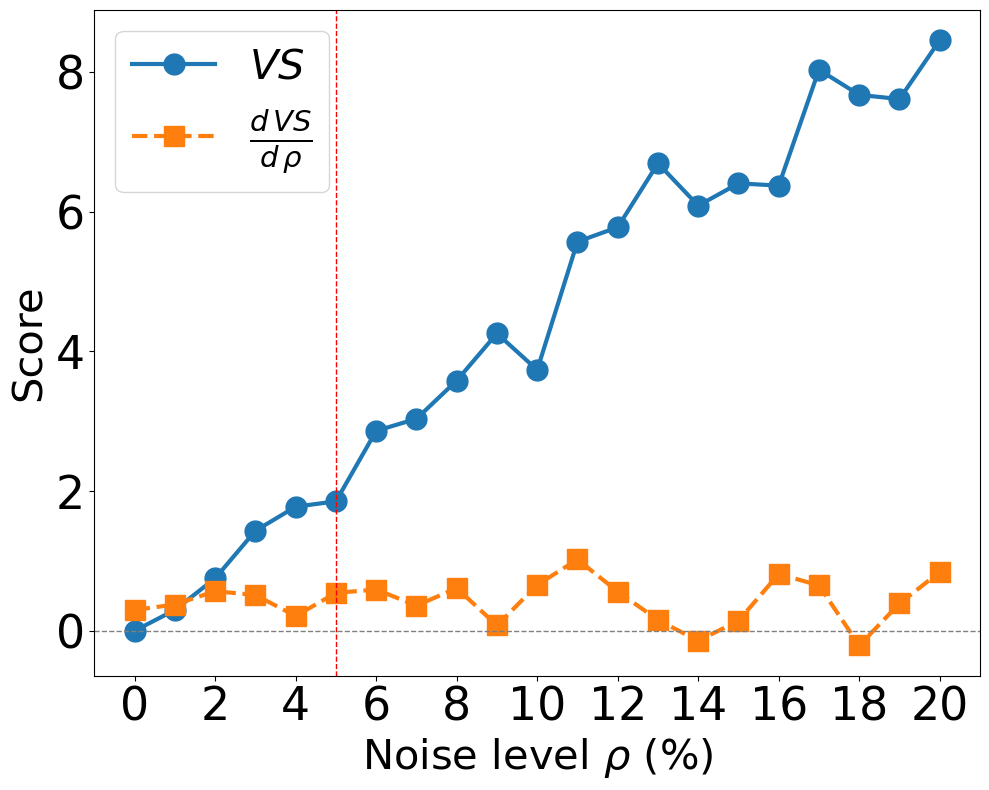

In [ ]:
folder_path = '/Users/hasan89/Documents/PipeLine/adult'
file_name = 'German_OI.pdf'
os.makedirs(folder_path, exist_ok=True)
file_path = os.path.join(folder_path, file_name)
plt.figure(figsize=(10, 8))

plt.figure(figsize=(10, 8))
plt.plot(missing_ratios_g, VS_score, 'o-', label='$VS$', markersize=15, linewidth=3)
plt.plot(missing_ratios_g, VS_gradient, 's--', label=r'$\frac{d\,VS}{d\,\rho}$', markersize=15, linewidth=3)

plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)
plt.axvline(x=5, color='r', linestyle='--', linewidth=1)

plt.xlabel(r'Noise level $\rho$ (%)', fontsize=30)
plt.ylabel('Score', fontsize=30)

xticks_to_show = missing_ratios_g[::2]
plt.xticks(xticks_to_show, fontsize=33)

plt.yticks(fontsize=33)
plt.legend(fontsize=30)
plt.tight_layout()
#plt.savefig(file_path, format='pdf', dpi=600)
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

SHAP-Based Importance of Preprocessing Components:
    Preprocessing Component  SHAP-Based Importance
0  Missing Value Imputation               0.005441
1                   Scaling               0.000065


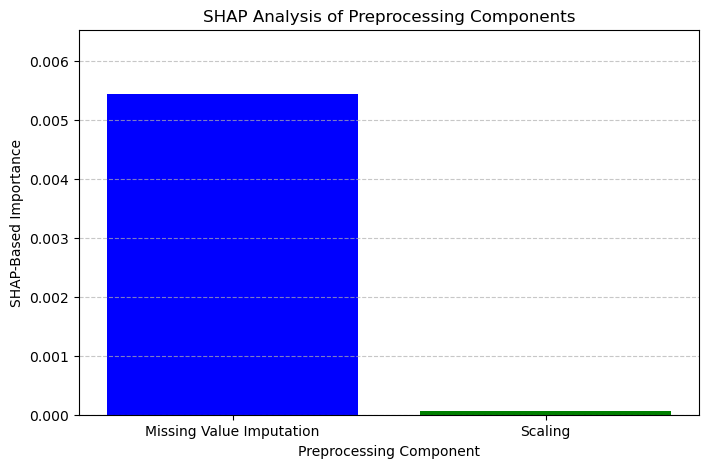

In [ ]:
import shap

def compute_shap_importance(X_train, X_test, y_train, y_test, preprocessing_step):
    model = LogisticRegression(random_state=42, max_iter=500)
    model.fit(X_train, y_train)
    explainer = shap.KernelExplainer(model.predict, X_train[:100])
    shap_values = explainer.shap_values(X_test[:100]
    shap_importance = np.mean(np.abs(shap_values))
    return shap_importance

X_train_no_prep, X_test_no_prep = X_train[numerical_features].fillna(0), X_test[numerical_features].fillna(0)
baseline_shap = compute_shap_importance(X_train_no_prep, X_test_no_prep, y_train, y_test, "No Preprocessing")

imputer = SimpleImputer(strategy="mean")
X_train_imputed = imputer.fit_transform(X_train[numerical_features])
X_test_imputed = imputer.transform(X_test[numerical_features])
imputation_shap = compute_shap_importance(X_train_imputed, X_test_imputed, y_train, y_test, "Imputation Only")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)
full_pipeline_shap = compute_shap_importance(X_train_scaled, X_test_scaled, y_train, y_test, "Imputation + Scaling")


imputation_importance_shap = imputation_shap - baseline_shap
scaling_importance_shap = full_pipeline_shap - imputation_shap


shap_importance_df = pd.DataFrame({
    "Preprocessing Component": ["Missing Value Imputation", "Scaling"],
    "SHAP-Based Importance": [imputation_importance_shap, scaling_importance_shap]
})


print("SHAP-Based Importance of Preprocessing Components:")
print(shap_importance_df)

plt.figure(figsize=(8, 5))
plt.bar(shap_importance_df["Preprocessing Component"], shap_importance_df["SHAP-Based Importance"], color=['blue', 'green'])
plt.xlabel("Preprocessing Component")
plt.ylabel("SHAP-Based Importance")
plt.title("SHAP Analysis of Preprocessing Components")
plt.ylim(0, max(shap_importance_df["SHAP-Based Importance"]) * 1.2)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
